Processing replica000...
Dipole for replica000: [3.327 0.    0.   ], Magnitude: 3.3270000000000013
Processing replica001...
Dipole for replica001: [3.327 0.    0.   ], Magnitude: 3.3270000000000013
Processing replica002...
Dipole for replica002: [3.327 0.    0.   ], Magnitude: 3.3270000000000013
Processing replica003...
Dipole for replica003: [3.327 0.    0.   ], Magnitude: 3.3270000000000013
Processing replica004...
Dipole for replica004: [3.327 0.    0.   ], Magnitude: 3.3270000000000013
Processing replica005...
Dipole for replica005: [3.327 0.    0.   ], Magnitude: 3.3270000000000013
Processing replica006...
Dipole for replica006: [3.327 0.    0.   ], Magnitude: 3.3270000000000013
Processing replica007...
Dipole for replica007: [3.327 0.    0.   ], Magnitude: 3.3270000000000013
Processing replica008...
Dipole for replica008: [3.327 0.    0.   ], Magnitude: 3.3270000000000013
Processing replica009...
Dipole for replica009: [3.327 0.    0.   ], Magnitude: 3.3270000000000013
Processing

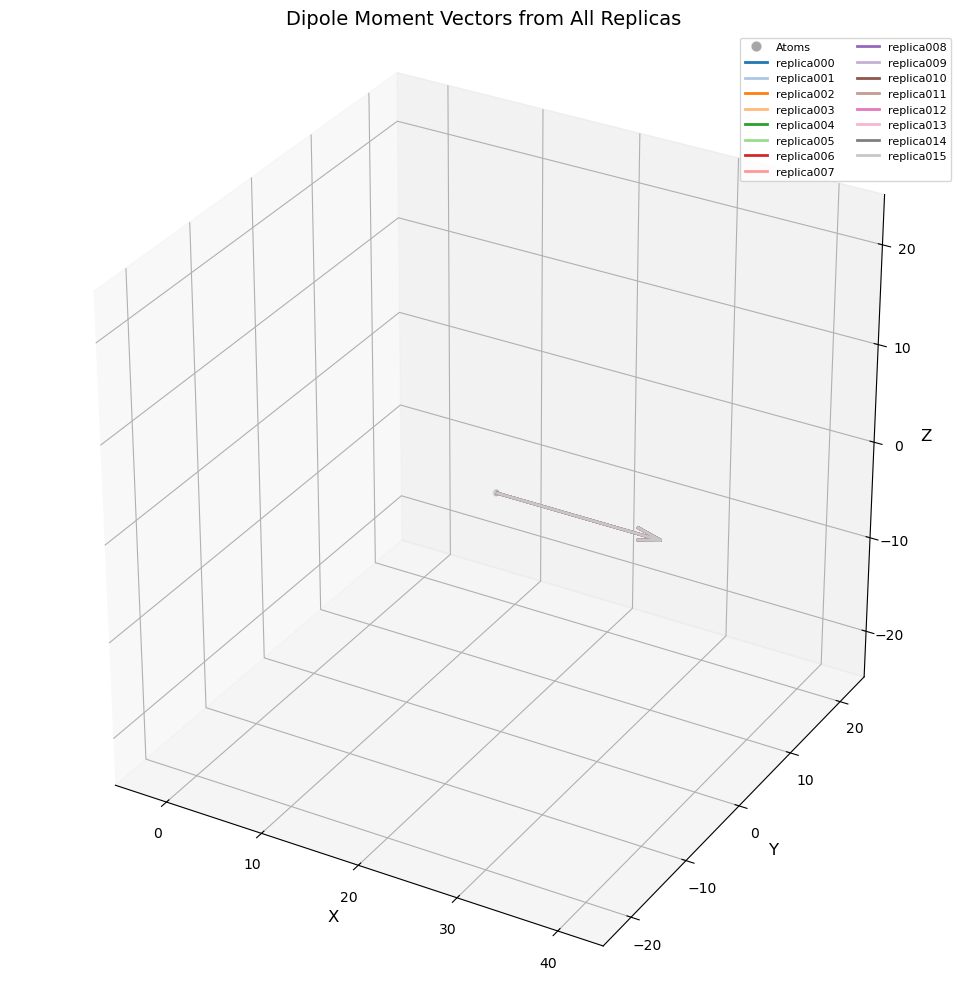

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib.colors as mcolors

# Define the base directory for the replicas
base_dir = "/home/hp/results/MOUSE/level3/F48Y"

# Define charges for the reactant state
charges_reactant = {
    1: -0.335, 2: 0.155, 3: 0.06, 4: 0.06, 5: 0.06, 6: 0.14, 7: 0.06, 8: -0.5, 9: 0.3,
    10: -0.418, 11: -0.418, 12: 0.418, 13: 0.418, 14: -0.76, 15: 0.38, 16: 0.38, 17: 0.5,
    18: -0.5, 19: -0.12, 20: 0.06, 21: 0.06, 22: -0.12, 23: 0.06, 24: 0.06
}

# Get list of replica directories (from replica000 to replica015)
replica_dirs = [f"replica{str(i).zfill(3)}" for i in range(16)]

# Create a 3D plot with a specific aspect ratio to make it compact
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Store all coordinates, dipoles and centers
all_coordinates = []
all_dipoles = []
all_centers = []
all_magnitudes = []
valid_replicas = []  # Keep track of which replicas have valid data

# Create a distinct color for each replica using a colormap
# Using a mix of distinct colors to make them easier to distinguish
colors = plt.cm.tab20(np.linspace(0, 1, 20))  # tab20 has 20 distinct colors
colors = np.vstack((colors, plt.cm.Set1(np.linspace(0, 1, 9))))  # Add more distinct colors
colors = colors[:len(replica_dirs)]  # Take only what we need

# First, collect all data from replicas
for i, replica in enumerate(replica_dirs):
    print(f"Processing {replica}...")
    
    # Create the full path to the reactant.csv file
    reactant_file = os.path.join(base_dir, replica, "reactant.csv")
    
    # Check if the file exists before proceeding
    if not os.path.exists(reactant_file):
        print(f"Warning: {reactant_file} does not exist. Skipping...")
        continue
    
    # Load reactant coordinates for the current replica
    try:
        reactant_data = pd.read_csv(reactant_file)
    except Exception as e:
        print(f"Error reading file for {replica}: {e}")
        continue

    # Determine the correct format of your coordinates
    try:
        if 'x' in reactant_data.columns and 'y' in reactant_data.columns and 'z' in reactant_data.columns:
            x_col, y_col, z_col = 'x', 'y', 'z'
        else:
            numerical_cols = reactant_data.select_dtypes(include=[np.number]).columns
            if len(numerical_cols) >= 3:
                x_col, y_col, z_col = numerical_cols[:3]
            else:
                x_col, y_col, z_col = reactant_data.columns[1], reactant_data.columns[2], reactant_data.columns[3]
        
        # Extract coordinates
        coordinates = np.array([
            reactant_data[x_col].values,
            reactant_data[y_col].values,
            reactant_data[z_col].values
        ]).T
        
        all_coordinates.append(coordinates)
        valid_replicas.append(replica)  # Track which replicas are valid
        
    except Exception as e:
        print(f"Error extracting coordinates for {replica}: {e}")
        continue
    
    # Ensure that the number of coordinates matches the number of charges
    num_atoms = len(coordinates)
    
    # Create a subset of charges based on the number of atoms
    charges_used = {}
    for j in range(min(num_atoms, len(charges_reactant))):
        charges_used[j+1] = charges_reactant[j+1]
    
    # Check for NaN or Inf values and handle them
    if np.any(np.isnan(coordinates)) or np.any(np.isinf(coordinates)):
        print(f"Warning: NaN or Inf values detected in coordinates for {replica}. Cleaning up...")
        coordinates = np.nan_to_num(coordinates, nan=0.0, posinf=0.0, neginf=0.0)

    # Calculate center of mass
    center_of_mass = np.mean(coordinates, axis=0)
    all_centers.append(center_of_mass)

    # Calculate dipole moment relative to center of mass
    dipole_moment = np.zeros(3)
    for j in range(len(charges_used)):
        if j < len(coordinates):  
            r_i = coordinates[j] - center_of_mass
            dipole_moment += charges_used[j+1] * r_i
    
    all_dipoles.append(dipole_moment)
    
    # Calculate dipole magnitude
    dipole_magnitude = np.linalg.norm(dipole_moment)
    all_magnitudes.append(dipole_magnitude)
    
    print(f"Dipole for {replica}: {dipole_moment}, Magnitude: {dipole_magnitude}")

# Calculate overall average center position to use as a reference
if all_centers:
    overall_center = np.mean(all_centers, axis=0)
else:
    overall_center = np.array([0, 0, 0])

# Find maximum dipole magnitude for scaling
if all_magnitudes:
    max_magnitude = max(all_magnitudes)
    min_magnitude = min([m for m in all_magnitudes if m > 0]) # Find minimum non-zero magnitude
else:
    max_magnitude = 1.0
    min_magnitude = 0.1

# Plot atoms from the first replica only (for clarity)
if all_coordinates:
    # Use first replica's coordinates for atoms, but make them small and transparent
    atom_plot = ax.scatter(all_coordinates[0][:, 0], all_coordinates[0][:, 1], all_coordinates[0][:, 2], 
              color='gray', s=30, alpha=0.3)

# Create explicit legend handlers
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                             markersize=8, label='Atoms', alpha=0.7)]

# Plot all dipole arrows starting from a common origin for better visualization
for i, (replica, dipole) in enumerate(zip(valid_replicas, all_dipoles)):
    # Skip if dipole is effectively zero
    dipole_magnitude = np.linalg.norm(dipole)
    if dipole_magnitude < 1e-10:
        print(f"Skipping dipole for {replica} - magnitude too small: {dipole_magnitude}")
        continue
    
    # Normalize and then scale by magnitude for better visibility
    # Scale factor determines arrow length - higher = longer arrows
    scale_factor = 5.0
    
    # Use a distinct color for each replica
    color = colors[i % len(colors)]
    
    # Plot the dipole arrow
    arrow = ax.quiver(overall_center[0], overall_center[1], overall_center[2],
             dipole[0], dipole[1], dipole[2],
             color=color, 
             linewidth=2,
             length=scale_factor * (dipole_magnitude / max_magnitude),
             arrow_length_ratio=0.15)
    
    # Add to legend elements
    legend_elements.append(plt.Line2D([0], [0], color=color, lw=2, label=f'{replica}'))
    
    print(f"Plotted dipole vector for {replica}")

# Create a small sphere at the origin
u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)
x = 0.3 * np.outer(np.cos(u), np.sin(v)) + overall_center[0]
y = 0.3 * np.outer(np.sin(u), np.sin(v)) + overall_center[1]
z = 0.3 * np.outer(np.ones(np.size(u)), np.cos(v)) + overall_center[2]
ax.plot_surface(x, y, z, color='lightgray', alpha=0.3)

# Calculate appropriate axis limits based on dipole vectors
if all_dipoles:
    max_coord = np.max(np.abs(all_dipoles)) * scale_factor * 1.5
    ax.set_xlim(overall_center[0] - max_coord, overall_center[0] + max_coord)
    ax.set_ylim(overall_center[1] - max_coord, overall_center[1] + max_coord)
    ax.set_zlim(overall_center[2] - max_coord, overall_center[2] + max_coord)
else:
    # Fallback to default limits if no data was processed
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-5, 5)

# Make the plot more compact by adjusting aspect ratio
ax.set_box_aspect([1, 1, 1])

# Set labels and title
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Z', fontsize=12)
ax.set_title('Dipole Moment Vectors from All Replicas', fontsize=14)

# Add grid for better visualization
ax.grid(True, alpha=0.3)

# Create the legend using our custom legend elements
# Split into two columns if there are many replicas
ncol = 2 if len(legend_elements) > 10 else 1
ax.legend(handles=legend_elements, loc='upper right', fontsize=8, ncol=ncol)

# Create a second figure for the molecular structure (optional)
show_molecule = False  # Set to True if you want to see the molecular structure separately
if show_molecule and len(all_coordinates) > 0:
    fig2 = plt.figure(figsize=(8, 6))
    ax2 = fig2.add_subplot(111, projection='3d')
    
    # Plot the molecular structure from the first replica
    first_coords = all_coordinates[0]
    ax2.scatter(first_coords[:, 0], first_coords[:, 1], first_coords[:, 2], 
               color='blue', s=50, alpha=0.7, label='Atoms')
               
    # Calculate appropriate limits for the molecular structure
    center = np.mean(first_coords, axis=0)
    max_range = np.max(np.max(np.abs(first_coords - center))) * 1.2
    
    ax2.set_xlim(center[0] - max_range, center[0] + max_range)
    ax2.set_ylim(center[1] - max_range, center[1] + max_range)
    ax2.set_zlim(center[2] - max_range, center[2] + max_range)
    
    ax2.set_xlabel('X', fontsize=10)
    ax2.set_ylabel('Y', fontsize=10)
    ax2.set_zlabel('Z', fontsize=10)
    ax2.set_title('Molecular Structure', fontsize=12)
    ax2.grid(True, alpha=0.3)

# Adjust layout and show plot
plt.tight_layout()
plt.show()